# Import necessary libraries

In [1]:
import sys
sys.path.append("../src")
import total
import utils
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import geopandas
from libpysal import weights
from gerrychain import Graph

img_dir = os.path.join(".", "geodesic_stills")

# Set constants (filenames, variables for drawing maps)

In [2]:
filename = "../IA_counties/IA_counties.shp"
voter_df = pd.read_csv("../data/voter_data.csv")
ia_graph = Graph.from_file(filename)
ia_counties = geopandas.read_file(filename)
ia_adj=nx.adjacency_matrix(ia_graph).toarray()
centroids = np.column_stack((ia_counties.centroid.x, ia_counties.centroid.y))
queen = weights.Queen.from_dataframe(ia_counties)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))
num_nodes = len(graph.nodes)

/usr/local/lib/python3.11/site-packages/gerrychain/graph/graph.py:179: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/var/folders/4x/f1jfbfg16zx42jnp08s19sc00000gn/T/ipykernel_63077/929576940.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((ia_counties.centroid.x, ia_counties.centroid.y))
/var/folders/4x/f1jfbfg16zx42jnp08s19sc00000gn/T/ipykernel_63077/929576940.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(ia_counties)


In [3]:
# compute the resistance distance matrix for a griven NX graph
def compute_graph_resistance(graph):
    ia_laplace = nx.laplacian_matrix(ia_graph).toarray()
    mpinv = np.linalg.pinv(ia_laplace)
    num_nodes = len(graph.nodes)
    metric = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            delta = np.zeros(num_nodes)
            delta[i] = 1
            delta[j] = -1
            metric[i,j] = (delta.T @ mpinv @ delta) 
    return metric

# compute the shortest path distance matrix for a given NX graph
def compute_graph_metric(graph):
    graph_dists = dict(nx.shortest_path_length(graph))
    sorted_dists = {k:sorted(v.items()) for k, v in graph_dists.items()}
    num_nodes = len(graph.nodes)
    dist_mat = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            dist_mat[i,j] = sorted_dists[i][j][1]
    
    return dist_mat

Now let's see an example of plotting our graph using the geometry of the shape file, and color according to the squared diffusion distance from a fixed node

Text(0.5, 1.0, 'Squared Distance from node 74 \n under the diffusion distance at time 1000')

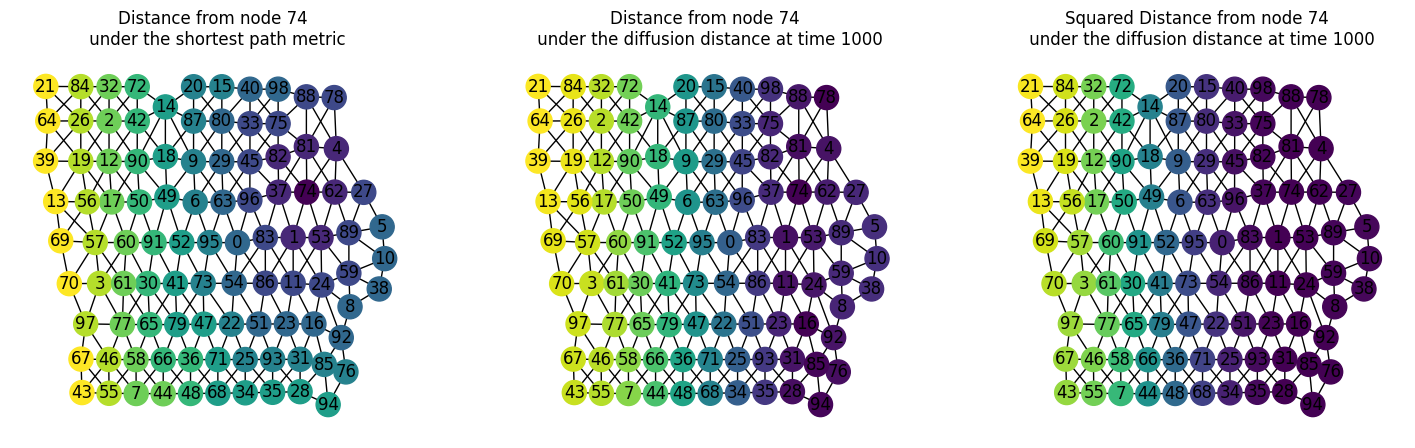

In [4]:
t = 1000 ## time parameter for the diffusion distance
graph_metric_cost = compute_graph_metric(graph)
ia_markov = utils.adj_mat_to_markov_chain(ia_adj)
diff_cost = utils.form_diffusion_map(ia_markov, t)
squared_diff_cost = diff_cost ** 2
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
fig.set_size_inches(18, 5)
size=300
n = 74
nx.draw(graph, positions, ax=ax0, node_size=size, with_labels=True, node_color=graph_metric_cost[n])
nx.draw(graph, positions, ax=ax1, node_size=size, with_labels=True, node_color=diff_cost[n])
nx.draw(graph, positions, ax=ax2, node_size=size, with_labels=True, node_color=squared_diff_cost[n])
ax0.set_title(f"Distance from node {n} \n under the shortest path metric")
ax1.set_title(f"Distance from node {n} \n under the diffusion distance at time {t}")
ax2.set_title(f"Squared Distance from node {n} \n under the diffusion distance at time {t}")

Now let's make our first animation. The following function creates an animation that illustrates how the diffusion distance from a node \(n\) changes over \(steps\) number of timesteps. That is to say, at each frame, we increment the time recompute the diffusion map, then we color the graph according to the distance from designated node. Note that this may take several minutes to run.

0
0
15
30
45
60
75
90
105
120
135


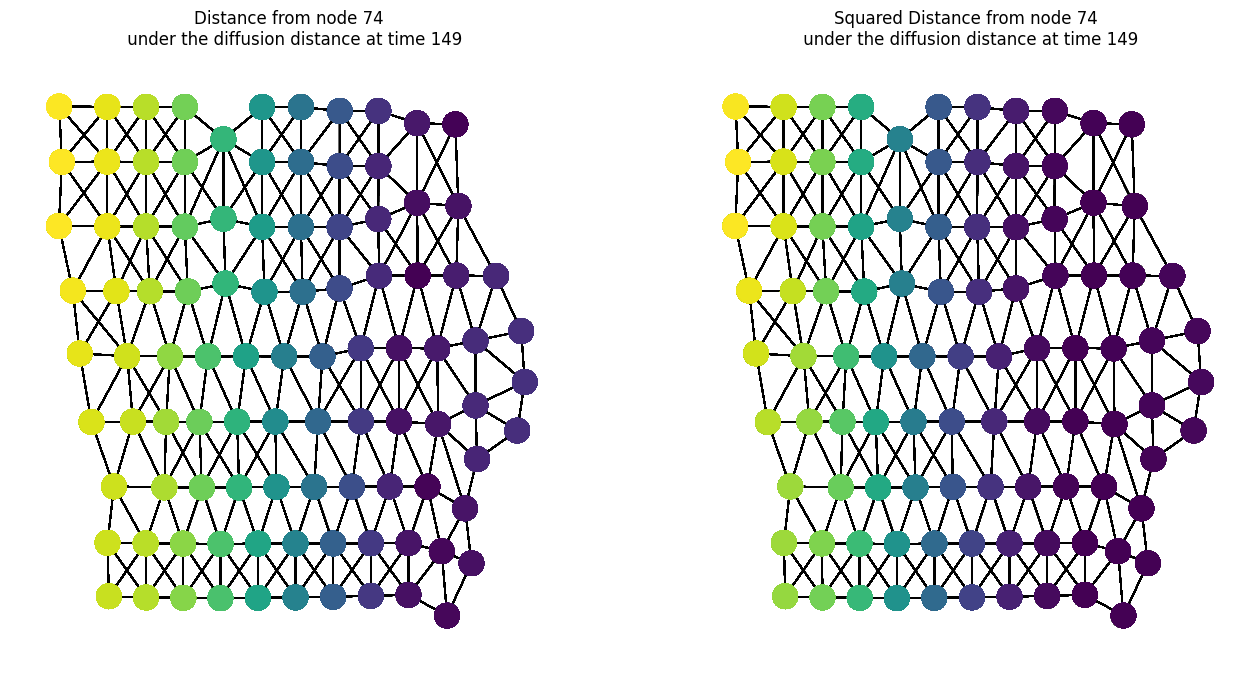

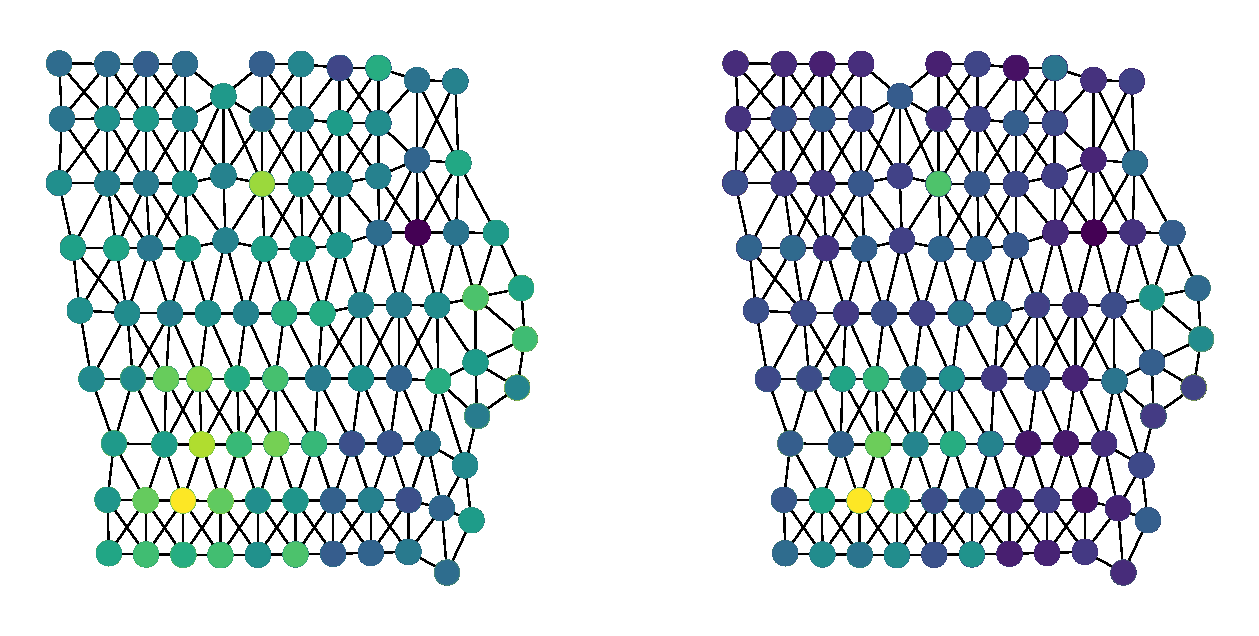

In [16]:
def animate_diff_dist(graph, steps=150, n=74, size=300, filename="ia_diffusion_evolution.mp4"):
    fig, (ax0, ax1) = plt.subplots(1,2)
    fig.set_size_inches(16, 8)
    ia_markov = utils.adj_mat_to_markov_chain(ia_adj)
    def update(frame):
        if frame % (int(steps/10)) == 0:
            print(frame)
        t = frame
        diff_cost = utils.form_diffusion_map(ia_markov, t)
        squared_diff_cost = diff_cost ** 2
        nx.draw(graph, positions, ax=ax0, node_size=size, node_color=diff_cost[n])
        nx.draw(graph, positions, ax=ax1, node_size=size, node_color=squared_diff_cost[n])
        ax0.set_title(f"Distance from node {n} \n under the diffusion distance at time {t}")
        ax1.set_title(f"Squared Distance from node {n} \n under the diffusion distance at time {t}")
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=100)
    ani.save(filename, writer='ffmpeg')

animate_diff_dist(graph)

Now, let's see what it looks like to interpolate two measures on the graph via Wasserstein barycenters. Here we will fix two measures, and compute their weight barycenter with weights (1,0), (1 - 1/steps, 1/steps), ... (0,1). Remember that each barycenter is a measure. The function below will draw each barycenter we compute in succession and produce an .mp4 file with the demonstration. 

In [9]:
# a function to animate a comparison between entropically regularized 1-Wass and 2-Wass barycentric interpolants
# as well as comparing our in-house code to taht which is publically available in the POT library
def animate_geodesic(measures, cost, filename, metric, epsilon=0.1, steps=50):
    geodesic = total.build_geodesic(measures, cost, epsilon, method="total", steps=steps, iters=2048)
    fig, ax0 = plt.subplots()
    fig.set_size_inches(10,10)
    def update(frame):
        size = 500
        nx.draw(graph, positions, ax=ax0, node_size=size, node_color=geodesic[:, frame])
        ax0.set_title(r"$W_2$ " +  f"Geodesic under {metric}\n Timestep : {frame + 1}")
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=100)
    ani.save(filename, writer='ffmpeg')
    return geodesic

computing with TOTAL implementation


<Axes: title={'center': '$W_2$ Geodesic under Squared Shortest Path Distance\n Timestep : 50'}>

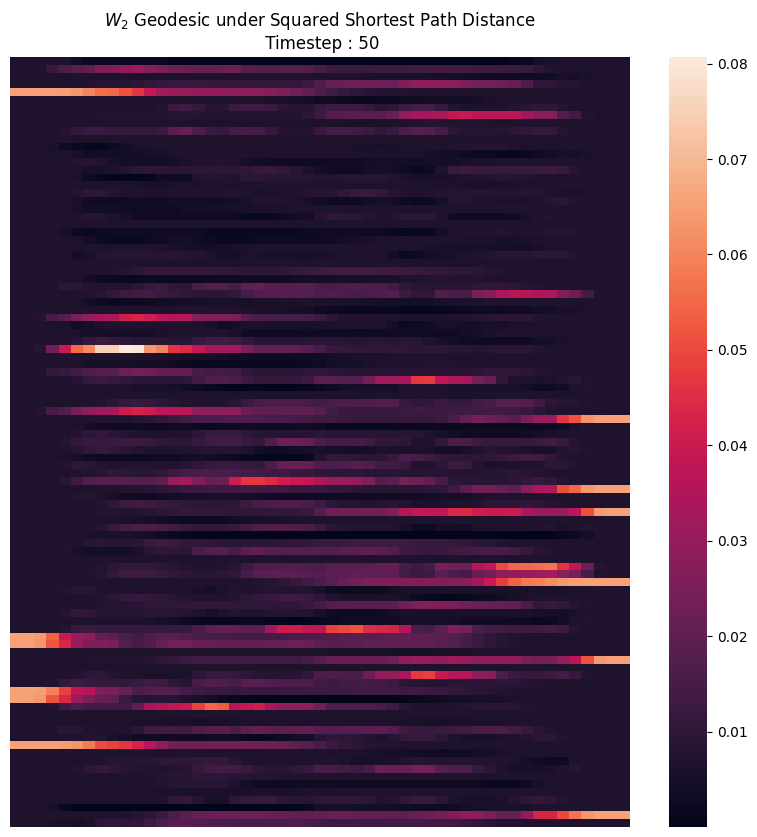

In [11]:
c0, c1 = 81, 46
t = 10
mu_0 = utils.random_geographic_concentration(ia_adj, center=c0)
mu_1 = utils.random_geographic_concentration(ia_adj, center=c1)
measures = np.stack((mu_0, mu_1)).T
shortest_path_cost = utils.compute_graph_metric(graph) ** 2
filename = f"w2-shortest-path-geodesic-{c0}-{c1}.mp4"
geo = animate_geodesic(measures, shortest_path_cost, filename, "Squared Shortest Path Distance")
sns.heatmap(geo)

Next, let's compare how our in house code compares to what you get from the Python OT Library

In [14]:
# a function to animate a comparison between entropically regularized 1-Wass and 2-Wass barycentric interpolants
# as well as comparing our in-house code to taht which is publically available in the POT library
def comparison_video(measures, cost, epsilon, steps, its, filename, metric, p=2):
    w2_geodesic = total.build_geodesic(measures, cost ** p, epsilon, method="total", steps=steps, iters=its)
    pot_w2_geodesic = total.build_geodesic(measures, cost ** p, epsilon, method="", steps=steps, iters=its)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20,10)
     
    def update(frame):
        size = 500
        nx.draw(graph, positions, ax=ax1, node_size=size, node_color=w2_geodesic[:, frame])
        nx.draw(graph, positions, ax=ax2, node_size=size, node_color=pot_w2_geodesic[:, frame])
        ax1.set_title(
            r"$W_{2}$ " + ":{metric}\n Timestep : {frame + 1}"
            )
        ax2.set_title(
            r"$W_{2}$ " + ": {metric}\n Timestep : {frame + 1}"
            )
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=100)
    ani.save(filename, writer='ffmpeg')

In [ ]:
c0, c1 = 78, 43
cost = utils.compute_graph_metric(graph)
mu_0 = utils.random_geographic_concentration(cost, center=c0)
mu_1 = utils.random_geographic_concentration(cost, center=c1)
measures = np.stack((mu_0, mu_1)).T
its = 2048
steps = 50
epsilon = 0.1
filename = f"ia-graph-metric-comparison.mp4"
comparison_video(measures, cost, epsilon, steps, its, filename, f"Shortest Path", p=p)

Finally, let's cap things off with a demonstration of barycentric regression. The simplest sanity check would be to compute a barycenter and see if we can recover its coodinates.

In [17]:
c0, c1, c2 = 81, 46, 26
mu_0 = utils.random_geographic_concentration(ia_adj, center=c0)
mu_1 = utils.random_geographic_concentration(ia_adj, center=c1)
mu_2 = utils.random_geographic_concentration(ia_adj, center=c2)
measures = np.stack((mu_0, mu_1, mu_2)).T
weights = np.array([1/3,1/3,1/3])
bar = total.barycenter(weights, measures, None, cost, epsilon, iters=2048)
recovered_coordinates = total.simplex_regression(measures, bar, cost, epsilon)
print(weights, recovered_coordinates)

[0.33333333 0.33333333 0.33333333] [0.33383033 0.3325157  0.33365397]
